In [1]:
from google.colab import drive
drive.mount('/content/drive')
# Copy data folder from drive to this machine
#!mkdir -p /content/images
# Copy the necessary files.
!cp /content/drive/MyDrive/Super_Resolution/images.tar.gz /content/images.tar.gz
!cp /content/drive/MyDrive/Super_Resolution/dataset.py /content/dataset.py
!cp /content/drive/MyDrive/Super_Resolution/losses.py /content/losses.py
!cp /content/drive/MyDrive/Super_Resolution/models.py /content/models.py
!cp /content/drive/MyDrive/Super_Resolution/trainer.py /content/trainer.py
!cp /content/drive/MyDrive/Super_Resolution/train.csv /content/train.csv
!cp /content/drive/MyDrive/Super_Resolution/val.csv /content/val.csv
!cp /content/drive/MyDrive/Super_Resolution/test.csv /content/test.csv

# Extract images
!tar -xzf /content/images.tar.gz

Mounted at /content/drive


# Import Dependencies

In [2]:
!pip install torcheval
!pip install torchinfo
!pip install piq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 1.5 MB/s eta 0:00:00


In [3]:
import torch
import pandas as pd
import torch.nn as nn
import trainer
import models
import torchinfo
import matplotlib.pyplot as plt
import dataset
from torch.utils.data import Dataset,DataLoader
from torcheval.metrics.functional import peak_signal_noise_ratio
from torchvision.transforms import ToTensor
from piq import ssim

In [4]:
# Some constants
test_data_path = '/content/test.csv'
test_df = pd.read_csv(test_data_path)
test_dataset = dataset.Data('/content/images',test_df,0.5,(300,300),ToTensor())

# Utils

In [5]:
def visualise_loss(trainer,loss_type):
  # Range of numbers
  x = range(len(trainer.train_history))  # Specify x-axis.

  plt.plot(x,trainer.train_history,label=f'Train {loss_type}',color='blue')
  plt.plot(x,trainer.val_history,label=f'Val {loss_type}',color='orange')

  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Epochs vs Loss')
  plt.legend()

  plt.show()


def visualise_psnr(trainer):
  # Range of numbers
  x = range(len(trainer.psnr_train))  # Specify x-axis.

  plt.plot(x,trainer.psnr_train,label=f'Train PSNR',color='blue')
  plt.plot(x,trainer.psnr_val,label=f'Val PSNR',color='orange')

  plt.xlabel('Epochs')
  plt.ylabel('PSNR')
  plt.title('Epochs vs PSNR')
  plt.legend()

  plt.show()


def test_loss_psnr(model,dataset):
  dataloader = DataLoader(dataset,batch_size=1,shuffle=False)

  test_loss = 0.0
  test_psnr = 0.0

  with torch.no_grad():
    for i,(image,image_downscaled) in enumerate(dataloader):
      loss,upscaled_image = model.train_step(image_downscaled,image)
      # Update loss and psnr
      test_loss += loss.cpu().item()
      test_psnr += peak_signal_noise_ratio(image,upscaled_image.cpu(),1.0).cpu().item()
    # Normalize
    test_loss = test_loss/len(dataset)
    test_psnr = test_psnr/len(dataset)

  return test_loss,test_psnr


def calculate_mssim(model,dataset):
  dataloader = DataLoader(dataset,batch_size=1,shuffle=False)

  test_ssim = 0.0

  with torch.no_grad():
    for i,(image,image_downscaled) in enumerate(dataloader):
      loss,upscaled_image = model.train_step(image_downscaled,image)
      # Update mssim.
      # Using a gaussian window size of 11 to calculate mssim.
      test_ssim += ssim(image, upscaled_image.cpu(), data_range=1.).item()

    # Normalize
    test_ssim = test_ssim/len(dataset)

  return test_ssim


def calculate_mae(model,dataset):

  dataloader = DataLoader(dataset,batch_size=1,shuffle=False)
  mae = nn.L1Loss()

  test_mae = 0.0

  with torch.no_grad():
    for i,(image,image_downscaled) in enumerate(dataloader):
      loss,upscaled_image = model.train_step(image_downscaled,image)
      # Update mae
      test_mae += mae(image,upscaled_image.cpu()).item()

    # Normalize
    test_mae = test_mae/len(dataset)

  return test_mae

# SRCNN with MSE Loss

## Setting Up

In [ ]:
args_mse = models.ModelArgs(loss = 'mse',
                        device = "cuda" if torch.cuda.is_available() else "cpu",
                        perceptual_loss_model = 'vgg16')
model_mse = models.SRCNN(args_mse)

This model (vgg16) won't be used. Its deleted from memory since we have selected mse loss to be our loss function. (Check `models.py`)

In [ ]:
# Model summary
torchinfo.summary(model_mse,input_size=(1,3,300,300))

Layer (type:depth-idx)                   Output Shape              Param #
SRCNN                                    [1, 3, 600, 600]          --
├─Sequential: 1-1                        [1, 3, 600, 600]          --
│    └─Conv2d: 2-1                       [1, 64, 600, 600]         15,616
│    └─Conv2d: 2-2                       [1, 32, 600, 600]         51,232
│    └─Conv2d: 2-3                       [1, 32, 600, 600]         9,248
│    └─Conv2d: 2-4                       [1, 3, 600, 600]          2,403
│    └─Sigmoid: 2-5                      [1, 3, 600, 600]          --
Total params: 78,499
Trainable params: 78,499
Non-trainable params: 0
Total mult-adds (G): 28.26
Input size (MB): 1.08
Forward/backward pass size (MB): 377.28
Params size (MB): 0.31
Estimated Total Size (MB): 378.67

In [ ]:
configs_mse = trainer.TrainConfigs(epochs = 10,
                               save_every = 2,
                               batch_size = 32,
                               save_path = '/content/drive/MyDrive/Super_Resolution/SRCNN_MSE',
                               images_path = '/content/images',
                               train_csv_path = '/content/train.csv',
                               val_csv_path = '/content/val.csv')

trainer_object_mse = trainer.Trainer(configs_mse,
                                 model_mse,
                                 torch.optim.Adam)

## Training

In [ ]:
trainer_object_mse.train()

185it [02:06,  1.46it/s, loss=0.00468, psnr=23.3]


Val loss: 0.004794861515164779 | Val psnr: 23.225737921439908


185it [02:06,  1.46it/s, loss=0.00433, psnr=23.6]


Val loss: 0.004106096023849952 | Val psnr: 23.90251763102489


185it [02:07,  1.45it/s, loss=0.00494, psnr=23.1]


Val loss: 0.0036726629900896016 | Val psnr: 24.386039178974734


185it [02:10,  1.42it/s, loss=0.00392, psnr=24.1]


Val loss: 0.003487620802649142 | Val psnr: 24.61812930178094


185it [02:09,  1.43it/s, loss=0.00409, psnr=23.9]


Val loss: 0.003351456581152401 | Val psnr: 24.784720466004657


185it [02:10,  1.42it/s, loss=0.00391, psnr=24.1]


Val loss: 0.0031607403985132666 | Val psnr: 25.037234826404124


185it [02:09,  1.43it/s, loss=0.00365, psnr=24.4]


Val loss: 0.003111022969087805 | Val psnr: 25.10221908734519


185it [02:06,  1.46it/s, loss=0.00358, psnr=24.5]


Val loss: 0.00299577257742145 | Val psnr: 25.27600352141467


185it [02:06,  1.46it/s, loss=0.00247, psnr=26.1]


Val loss: 0.0030331317226985955 | Val psnr: 25.21380373137891


185it [02:08,  1.44it/s, loss=0.00334, psnr=24.8]


Val loss: 0.002844619197980154 | Val psnr: 25.50270523979796


In [ ]:
# Save model
trainer_object_mse.save()

## Loss Curves

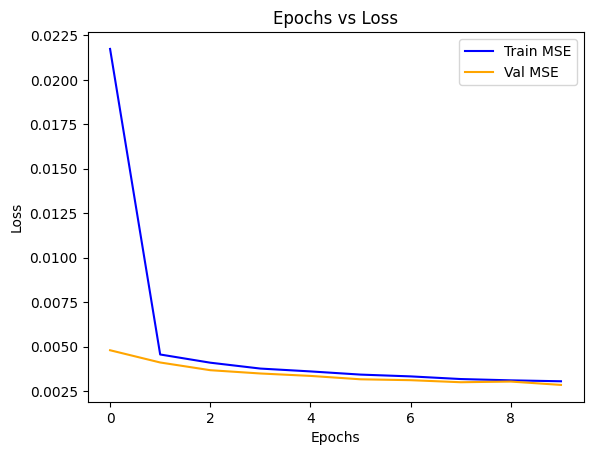

In [ ]:
visualise_loss(trainer_object_mse,'MSE')

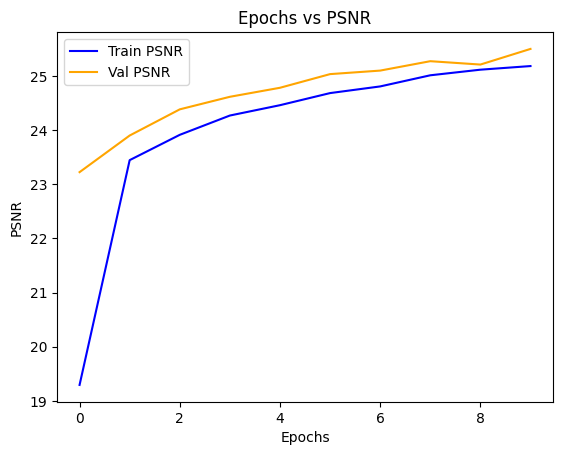

In [ ]:
visualise_psnr(trainer_object_mse)

# Test Metrics

In [ ]:
test_loss,test_psnr = test_loss_psnr(trainer_object_mse.model,test_dataset)
test_mssim = calculate_mssim(trainer_object_mse.model,test_dataset)

print(f"SRCNN_mse Test Loss: {test_loss}")
print(f"SRCNN_mse Test PSNR: {test_psnr}")
print(f"SRCNN_mse Test MSSIM: {test_mssim}")

SRCNN_mse Test Loss: 0.0029591793857303137
SRCNN_mse Test PSNR: 26.103219702053458
SRCNN_mse Test MSSIM: 0.77314482439758


# SRCNN with Perceptual Loss

## Setting Up

In [ ]:
args_perceptual = models.ModelArgs(loss = 'perceptual',
                        device = "cuda" if torch.cuda.is_available() else "cpu",
                        perceptual_loss_model = 'vgg16',
                        selected_layers = (3,8,15,29))
model_perceptual = models.SRCNN(args_perceptual)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 88.5MB/s]


In [ ]:
# Model summary
torchinfo.summary(model_perceptual,input_size=(1,3,300,300))

Layer (type:depth-idx)                   Output Shape              Param #
SRCNN                                    [1, 3, 600, 600]          14,714,688
├─Sequential: 1-1                        [1, 3, 600, 600]          --
│    └─Conv2d: 2-1                       [1, 64, 600, 600]         15,616
│    └─Conv2d: 2-2                       [1, 32, 600, 600]         51,232
│    └─Conv2d: 2-3                       [1, 32, 600, 600]         9,248
│    └─Conv2d: 2-4                       [1, 3, 600, 600]          2,403
│    └─Sigmoid: 2-5                      [1, 3, 600, 600]          --
Total params: 14,793,187
Trainable params: 78,499
Non-trainable params: 14,714,688
Total mult-adds (G): 28.26
Input size (MB): 1.08
Forward/backward pass size (MB): 377.28
Params size (MB): 0.31
Estimated Total Size (MB): 378.67

In [ ]:
configs_perceptual = trainer.TrainConfigs(epochs = 10,
                               save_every = 2,
                               batch_size = 32,
                               save_path = '/content/drive/MyDrive/Super_Resolution/SRCNN_Perceptual',
                               images_path = '/content/images',
                               train_csv_path = '/content/train.csv',
                               val_csv_path = '/content/val.csv')

trainer_object_perceptual = trainer.Trainer(configs_perceptual,
                                 model_perceptual,
                                 torch.optim.Adam)

## Training

In [ ]:
trainer_object_perceptual.train()

185it [04:54,  1.59s/it, loss=1.47, psnr=16.7]


Val loss: 1.5097954986221251 | Val psnr: 16.67041084795424


185it [04:56,  1.60s/it, loss=1.26, psnr=18.9]


Val loss: 1.2800079075183532 | Val psnr: 18.480114963928965


185it [04:56,  1.61s/it, loss=1.49, psnr=19.9]


Val loss: 1.2046383219255645 | Val psnr: 19.316445966212125


185it [04:57,  1.61s/it, loss=1.17, psnr=19.5]


Val loss: 1.1657478549644975 | Val psnr: 20.033839637436305


185it [04:50,  1.57s/it, loss=0.986, psnr=21.4]


Val loss: 1.1494005599912351 | Val psnr: 20.858551838401205


185it [04:47,  1.56s/it, loss=1.5, psnr=20.2]


Val loss: 1.133942859743864 | Val psnr: 20.760767703127314


185it [04:46,  1.55s/it, loss=1.19, psnr=20.2]


Val loss: 1.1265619784311287 | Val psnr: 20.519405282398683


185it [04:46,  1.55s/it, loss=1.1, psnr=21]


Val loss: 1.120969180405866 | Val psnr: 20.929137339611337


185it [04:47,  1.55s/it, loss=1.17, psnr=20.5]


Val loss: 1.1001808304586655 | Val psnr: 21.23337469501005


185it [04:47,  1.55s/it, loss=1.18, psnr=21.4]


Val loss: 1.110292823776018 | Val psnr: 21.214477655206867


In [ ]:
trainer_object_perceptual.save()

## Loss Curves

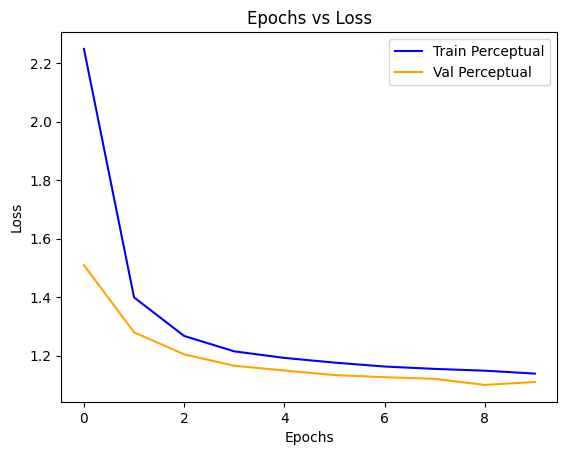

In [ ]:
visualise_loss(trainer_object_perceptual,'Perceptual')

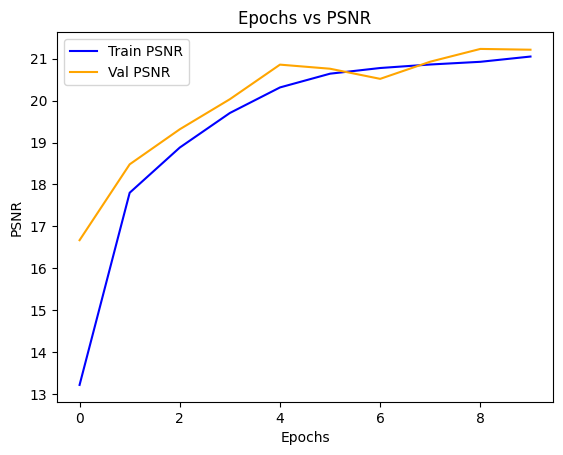

In [ ]:
visualise_psnr(trainer_object_perceptual)

## Test Metrics

In [ ]:
test_loss,test_psnr = test_loss_psnr(trainer_object_perceptual.model,test_dataset)
test_mssim = calculate_mssim(trainer_object_perceptual.model,test_dataset)

print(f"SRCNN_perceptual Test Loss: {test_loss}")
print(f"SRCNN_perceptual Test PSNR: {test_psnr}")
print(f"SRCNN_perdeptual Test MSSIM: {test_mssim}")

SRCNN_mse Test Loss: 1.0891260658069457
SRCNN_mse Test PSNR: 21.68500958856936
SRCNN_mse Test MSSIM: 0.7604835231628405


# SRCNN MSE with Weighted Perceptual Loss

## Setting Up

In [6]:
args_mse_percp = models.ModelArgs(loss = 'perceptual_mse',
                        device = "cuda" if torch.cuda.is_available() else "cpu",
                        perceptual_loss_model = 'vgg16',
                        perceptual_weight=0.001)
model_mse_percp = models.SRCNN(args_mse_percp)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 95.1MB/s]


In [7]:
# Model summary
torchinfo.summary(model_mse_percp,input_size=(1,3,300,300))

Layer (type:depth-idx)                   Output Shape              Param #
SRCNN                                    [1, 3, 600, 600]          14,714,688
├─Sequential: 1-1                        [1, 3, 600, 600]          --
│    └─Conv2d: 2-1                       [1, 64, 600, 600]         15,616
│    └─Conv2d: 2-2                       [1, 32, 600, 600]         51,232
│    └─Conv2d: 2-3                       [1, 32, 600, 600]         9,248
│    └─Conv2d: 2-4                       [1, 3, 600, 600]          2,403
│    └─Sigmoid: 2-5                      [1, 3, 600, 600]          --
Total params: 14,793,187
Trainable params: 78,499
Non-trainable params: 14,714,688
Total mult-adds (G): 28.26
Input size (MB): 1.08
Forward/backward pass size (MB): 377.28
Params size (MB): 0.31
Estimated Total Size (MB): 378.67

In [8]:
configs_mse_percp = trainer.TrainConfigs(epochs = 10,
                               save_every = 2,
                               batch_size = 32,
                               save_path = '/content/drive/MyDrive/Super_Resolution/SRCNN_MSE_Perceptual',
                               images_path = '/content/images',
                               train_csv_path = '/content/train.csv',
                               val_csv_path = '/content/val.csv')

trainer_object_mse_percp = trainer.Trainer(configs_mse_percp,
                                 model_mse_percp,
                                 torch.optim.Adam)

## Training

In [9]:
trainer_object_mse_percp.train()

185it [04:48,  1.56s/it, loss=0.0086, psnr=22.5]


Val loss: 0.007607483098356504 | Val psnr: 23.251367282480285


185it [05:06,  1.66s/it, loss=0.0065, psnr=24]


Val loss: 0.0062995564875587395 | Val psnr: 24.2552811825227


185it [05:04,  1.65s/it, loss=0.00618, psnr=24.2]


Val loss: 0.005826797633128132 | Val psnr: 24.58523616352004


185it [05:04,  1.65s/it, loss=0.00566, psnr=24.7]


Val loss: 0.005457659323191893 | Val psnr: 24.825041545098784


185it [04:55,  1.60s/it, loss=0.00522, psnr=25]


Val loss: 0.005209340543784856 | Val psnr: 24.964834633957548


185it [04:55,  1.60s/it, loss=0.00465, psnr=25.3]


Val loss: 0.004873889877746973 | Val psnr: 25.250621289781048


185it [04:53,  1.58s/it, loss=0.00421, psnr=25.9]


Val loss: 0.004758693204741517 | Val psnr: 25.332135981248744


185it [04:54,  1.59s/it, loss=0.00512, psnr=24.8]


Val loss: 0.004595414267825177 | Val psnr: 25.43427369526823


185it [04:55,  1.60s/it, loss=0.00548, psnr=24.5]


Val loss: 0.0044866454512188375 | Val psnr: 25.48107065915739


185it [04:55,  1.60s/it, loss=0.0044, psnr=25.3]


Val loss: 0.00439312437414387 | Val psnr: 25.552999648738133


In [10]:
trainer_object_mse_percp.save()

## Loss Curves

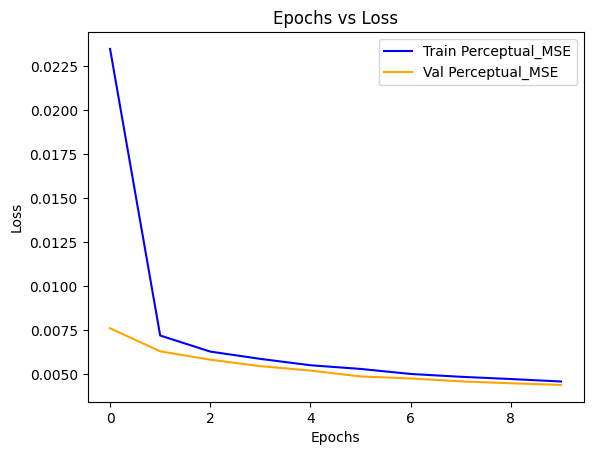

In [11]:
visualise_loss(trainer_object_mse_percp,'Perceptual_MSE')

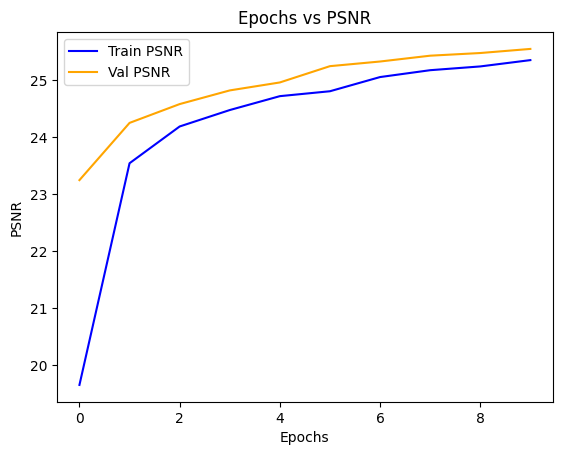

In [12]:
visualise_psnr(trainer_object_mse_percp)

## Test Metrics

In [13]:
test_loss,test_psnr = test_loss_psnr(trainer_object_mse_percp.model,test_dataset)
test_mssim = calculate_mssim(trainer_object_mse_percp.model,test_dataset)

print(f"SRCNN_mse_perceptual Test Loss: {test_loss}")
print(f"SRCNN_mse_perceptual Test PSNR: {test_psnr}")
print(f"SRCNN_mse_perceptual Test MSSIM: {test_mssim}")

SRCNN_mse_perceptual Test Loss: 0.004550829917130707
SRCNN_mse_perceptual Test PSNR: 26.023287927991483
SRCNN_mse_perceptual Test MSSIM: 0.7797328351476357
